### Méthodes pour preprocessing

In [1]:
import string
import nltk
nltk.download('wordnet')
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

[nltk_data] Downloading package wordnet to /home/slerendu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def preprocessing_words(df, col, stem_or_lemma="stem", debug=False):
    """
    
    """
    result = []    
    # building stopwords list
    stopW = stopwords.words('english')
    stopW.extend(string.punctuation)
    
    for index, row in df.iterrows():
        temp_res = ""
        # normalisation
        temp_res = row[col].lower()
        # tokenization
        temp_res = tokenize.word_tokenize(temp_res)
        # remove stopwords
        temp_res = [word for word in temp_res if word not in stopW]
        
        # stemmation or lemmatization
        if stem_or_lemma == "stem":
            stemmer = PorterStemmer()
            temp_res = [stemmer.stem(elt) for elt in temp_res]
        elif stem_or_lemma == "lemma":
            lemmatizer = WordNetLemmatizer()
            temp_res = [lemmatizer.lemmatize(elt, "v") for elt in temp_res]
        else:
            print("stem or lemma only")
        
        result.append(temp_res)
    return result

In [3]:
def filter_pos_tag(df, col, tags_to_remove=[], debug=False):
    """
    
    """
    result = []
    if not tags_to_remove:
        print("Aucun filtre n'a été défini.")
        return df[col]
    for index, row in df.iterrows():
        temp_res = pos_tag(row[col])
        temp_res = [x for x in temp_res if x[1] not in tags_to_remove]
        # if debug:
        #     print(temp_res[0])
        result.append([x[0] for x in temp_res])
    return result

In [4]:
def filter_exclude_words(df, col, words_to_exclude=[], debug=False):
    """
    
    """
    result = []
    if not words_to_exclude:
        print("Aucun mots à exclure.")
        return df[col]
    for index, row in df.iterrows():
        result.append([x for x in row[col] if x not in words_to_exclude])
    return result

In [5]:
def display_wordcloud(corpus, debug=False):
    wordcloud = WordCloud(
            random_state = 42,
            normalize_plurals = False,
            width = 600, 
            height= 300,
            max_words = 100,
            stopwords = [])

    concat = " ".join(corpus)
    wordcloud.generate(concat)
    
    fig, ax = plt.subplots(1,1, figsize = (12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

### Import des données

In [6]:
import numpy as np
import pandas as pd

In [7]:
data = pd.read_csv('study_dataset.csv', encoding='utf-8', sep='\t', index_col=0)
data.head()

,business_id,name,stars,text
882258,TyYpzJzeKWtyMdPFtPRUEg,Prince Pizza,1,This place was horrible! They got my entire or...
642407,LCMpkeQWHdCbuX0Nlkmeow,Jack in the Box,1,I have no idea why I bother. It's the closest ...
831418,AZ42H2kk4JUiskC9NPoUjw,Hobnobber's Variety Bar & Restaurant,1,After reading glowing reviews of staff and foo...
452134,0CeoONLXqseUxPdGerefOQ,Mexican Post,1,Horrible Ground beef/bean Chimichanga. There w...
921422,QYEiZzwL8I4-q_3U0bq0eQ,The Nutrition Factory,1,They are usually awesome but picked up a kale ...


In [8]:
# nombre de reviews
data.shape

(3887, 4)

In [9]:
# nombre de restaurants
data["business_id"].nunique()

3404

### Preprocessing

In [10]:
def natural_language_processing(df, col, stem_or_lemma="stem", tags_to_remove=[], max_threshold=999, min_threshold=0, word_cloud=True, words_to_exclude=[], debug=False):
    # df = input_df.copy()
    # preprocessing part
    preproc_res = preprocessing_words(df, col, stem_or_lemma=stem_or_lemma, debug=debug)
    df.insert(0, 'preproc_text', preproc_res)
    # if debug:
    #     display(df[[col, 'preproc_text']].head())
    
    # filter by pos tag part
    filtpos_res = filter_pos_tag(df, "preproc_text", tags_to_remove=tags_to_remove, debug=debug)
    df.insert(0, 'filtpos_text', filtpos_res)
    # if debug:
    #     display(df[[col, 'preproc_text', 'filtpos_text']].head())
    
    # filter by excluding words
    filtexcl_words = filter_exclude_words(df, "filtpos_text", words_to_exclude=words_to_exclude, debug=debug)
    df.insert(0, 'filtexcl_words', filtexcl_words)
    
    if debug:
        display(df[[col, 'preproc_text', 'filtpos_text', 'filtexcl_words']].head())
    
    # concatenate all documents into a single corpus
    corpus = df["filtexcl_words"].tolist()
    corpus = [item for sublist in corpus for item in sublist]
    
    word_counts = Counter(corpus)
    print("Il y a un total de", len(word_counts), "mots différents dans tout le corpus.")
    word_counts_threshold = {x: count for x, count in word_counts.items() if count > min_threshold}
    word_counts_threshold = {x: count for x, count in word_counts_threshold.items() if count < max_threshold}
    print("Après filtre des mots aparaissant moins de", min_threshold, "fois, il reste", len(word_counts_threshold), "mots différents dans tout le corpus.\n")
    word_counts = Counter(word_counts_threshold)
    
    if debug:
        print("------------ Top 20 plus communs : ------------")
        display_most_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common(20)]
        for elt in display_most_common:
            print(elt)
        print("\n------------ Top 20 moins communs : ------------")
        display_least_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common()[-20:]]
        for elt in display_least_common:
            print(elt)
        
    simplified_corpus = word_counts_threshold.keys()
    
    # display wordcloud part
    if word_cloud:
        display_wordcloud(simplified_corpus, debug=debug)
    
    return simplified_corpus

,text,preproc_text,filtpos_text,filtexcl_words
882258,This place was horrible! They got my entire or...,"[place, horrible, get, entire, order, wrong, e...","[place, get, order, repeat, order, moms, come,...","[place, get, order, repeat, order, moms, see, ..."
642407,I have no idea why I bother. It's the closest ...,"[idea, bother, 's, closest, home, guess, alway...","[idea, bother, closest, home, guess, order, ea...","[idea, bother, closest, home, guess, order, ea..."
831418,After reading glowing reviews of staff and foo...,"[read, glow, review, staff, food, disappoint, ...","[read, review, staff, food, disappoint, custom...","[read, review, staff, food, disappoint, custom..."
452134,Horrible Ground beef/bean Chimichanga. There w...,"[horrible, grind, beef/bean, chimichanga, way,...","[grind, way, way, bean, beef, process, form, p...","[grind, way, way, bean, beef, process, form, p..."
921422,They are usually awesome but picked up a kale ...,"[usually, awesome, pick, kale, caesar, salad, ...","[kale, caesar, salad, person, idea, caesar, sa...","[kale, caesar, salad, person, idea, caesar, sa..."


Il y a un total de 9560 mots différents dans tout le corpus.
Après filtre des mots aparaissant moins de 50 fois, il reste 481 mots différents dans tout le corpus.

------------ Top 20 plus communs : ------------
('time', 2013, 1.526133038164698)
('service', 1632, 1.2372822246819608)
('minutes', 1061, 0.8043850737668876)
('eat', 946, 0.7171991326894209)
('ask', 927, 0.7027944989461873)
('wait', 831, 0.6300131916119543)
('taste', 759, 0.5754272111112796)
('experience', 695, 0.5269063395551243)
('drink', 684, 0.5185668147564101)
('people', 662, 0.5018877651589817)
('chicken', 645, 0.4889994086518779)
('better', 603, 0.457157586693151)
('way', 594, 0.45033433913056664)
('look', 585, 0.4435110915679823)
('manager', 562, 0.42607390335248896)
('price', 557, 0.4222832102621643)
('bar', 543, 0.4116692696092553)
('staff', 540, 0.4093948537550606)
('sit', 516, 0.39119952692150234)
('night', 493, 0.373762338706009)

------------ Top 20 moins communs : ------------
('good', 53, 0.04018134675744113)

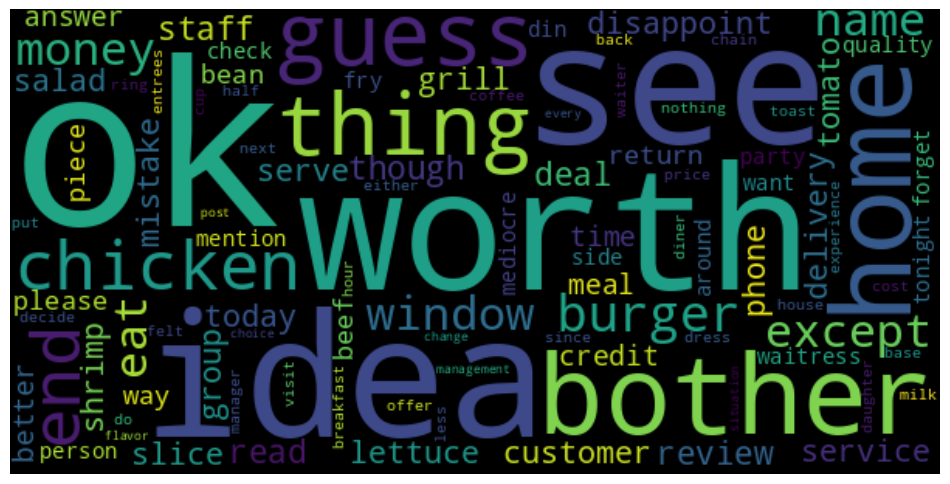

In [11]:
# words_to_exclude = ["food", "order", "get"] # top 3 (> 1.5% de frquence)
words_to_exclude = ["``", "''", ".", "..", "...", "....", "....."] # ponctuation restante dans le top 10
words_to_exclude += ["restaurant", "like", "go", "come", "try", "tell", "take", "another"] # suppression
corpus = natural_language_processing(data, "text", stem_or_lemma="lemma", words_to_exclude=words_to_exclude,
                                     tags_to_remove=["JJ", "RB", "MD", "POS", "CD", ":", "PRP", "VBP"],
                                     max_threshold=2050, min_threshold=50, debug=True)

In [12]:
truc = bidule

NameError: name 'bidule' is not defined

### Bag of Words Td-Idf

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
vect = TfidfVectorizer()
tfidf_mat = vect.fit_transform(corpus)
features_names = vect.get_feature_names_out()

### Show topics

In [16]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [17]:
def get_topics(model, feature_names, no_top_words):
    word_dict = {};
    for topic_idx, topic in enumerate(model.components_):
        word_dict['Topic' + '{:02d}'.format(topic_idx+1)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    display(pd.DataFrame(word_dict).head(no_top_words))
    return word_dict

### LDA

In [18]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis

In [19]:
def display_lda(tf, n_components):
    lda = LatentDirichletAllocation(
            n_components=n_components, 
            max_iter=5, 
            learning_method='online', 
            learning_offset=50.,
            random_state=42)

    # Fitter sur les données
    lda.fit(tf)

    no_top_words = 10
    # display_topics(lda, features_names, no_top_words)
    word_dict = get_topics(lda, features_names, no_top_words)

In [20]:
# for n_topics in range(6, 21, 2):
#     print("-"*70)
#     print("Compute", n_topics, "topics...")
#     display_lda(tfidf_mat, n_topics)

### NMF

In [21]:
from sklearn.decomposition import NMF

In [22]:
def display_nmf(tf, n_components):
    nmf = NMF(n_components=n_components, random_state=1, l1_ratio=.5, init='nndsvd')
    nmf.fit(tf)

    no_top_words = 10
    # display_topics(nmf, features_names, no_top_words)
    get_topics(nmf, features_names, no_top_words)

In [23]:
# for n_topics in range(6, 21, 2):
#     print("-"*70)
#     print("Compute", n_topics, "topics...")
#     display_nmf(tfidf_mat, n_topics)

### Gensim

In [24]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.model_selection import ParameterGrid
from gensim.models.coherencemodel import CoherenceModel

In [25]:
documents = data["filtexcl_words"].tolist()

In [26]:
simplified_documents = []
for doc in documents:
    simplified_documents.append([x for x in doc if x in corpus])    

In [27]:
dictionary = Dictionary(simplified_documents)
corpus_gensim = [dictionary.doc2bow(doc) for doc in simplified_documents]

In [28]:
# dictionary = Dictionary(documents)
# corpus = [dictionary.doc2bow(doc) for doc in documents]

In [29]:
# Définition des paramètres à tester
param_grid = {
    'num_topics': [5, 10, 15, 20],
    'passes': [20, 30, 40]
}

In [30]:
# Liste pour stocker les résultats
results = []
# Variables pour stocker le meilleur modèle et son score de cohérence
best_model = None
best_coherence_score = -1

# Grid Search
for params in ParameterGrid(param_grid):
    # Entraînement du modèle LDA avec les paramètres donnés
    lda_model = LdaModel(corpus=corpus_gensim, id2word=dictionary, **params)
    
    # Calcul de la cohérence des sujets
    coherence_model = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Stockage des résultats
    results.append((params, coherence_score))
    
    # Mise à jour du meilleur modèle si le score de cohérence est plus élevé
    if coherence_score > best_coherence_score:
        best_model = lda_model
        best_coherence_score = coherence_score    

In [31]:
results

[({'num_topics': 5, 'passes': 20}, 0.44758670305590753),
 ({'num_topics': 5, 'passes': 30}, 0.4697275102463439),
 ({'num_topics': 5, 'passes': 40}, 0.4636645595444008),
 ({'num_topics': 10, 'passes': 20}, 0.45002683670637156),
 ({'num_topics': 10, 'passes': 30}, 0.44229041207141123),
 ({'num_topics': 10, 'passes': 40}, 0.41635086900546864),
 ({'num_topics': 15, 'passes': 20}, 0.42771255582733064),
 ({'num_topics': 15, 'passes': 30}, 0.41994168045017793),
 ({'num_topics': 15, 'passes': 40}, 0.4238314512420566),
 ({'num_topics': 20, 'passes': 20}, 0.40245651690408046),
 ({'num_topics': 20, 'passes': 30}, 0.41313557548336244),
 ({'num_topics': 20, 'passes': 40}, 0.3946142976974186)]

In [32]:
# Affichage du meilleur modèle et de son score de cohérence
print("Meilleur modèle :")
print(best_model)
print("Score de cohérence des sujets :", best_coherence_score)

print("\n", "=====================================", "\n")

# Affichage des thèmes pour best_model
topics = best_model.print_topics(num_topics=20, num_words=10)
for topic in topics:
    print(topic)

Meilleur modèle :
LdaModel<num_terms=481, num_topics=5, decay=0.5, chunksize=2000>
Score de cohérence des sujets : 0.4697275102463439


(0, '0.024*"taste" + 0.017*"eat" + 0.014*"better" + 0.014*"service" + 0.013*"side" + 0.013*"price" + 0.013*"steak" + 0.013*"egg" + 0.012*"time" + 0.012*"coffee"')
(1, '0.049*"minutes" + 0.040*"wait" + 0.034*"time" + 0.033*"service" + 0.025*"ask" + 0.024*"drink" + 0.020*"waitress" + 0.018*"check" + 0.017*"server" + 0.017*"experience"')
(2, '0.043*"time" + 0.022*"service" + 0.022*"call" + 0.019*"manager" + 0.019*"customer" + 0.017*"ask" + 0.016*"people" + 0.014*"customers" + 0.014*"pay" + 0.014*"work"')
(3, '0.045*"chicken" + 0.032*"pizza" + 0.025*"taste" + 0.021*"sauce" + 0.020*"eat" + 0.019*"rice" + 0.018*"fry" + 0.017*"time" + 0.016*"meat" + 0.014*"flavor"')
(4, '0.040*"bar" + 0.020*"room" + 0.020*"drink" + 0.019*"service" + 0.018*"beer" + 0.016*"area" + 0.016*"staff" + 0.016*"sit" + 0.015*"night" + 0.013*"around"')


In [33]:
# from pyLDAvis import gensim as ldavis_gen
# model = LdaModel(corpus=corpus_gensim, id2word=dictionary, num_topics=15)
# lda_display = ldavis_gen.prepare(model, corpus_gensim, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display)

### WordEmbedding

In [34]:
import gensim.downloader as api
model = api.load("word2vec-google-news-300")

In [35]:
model.most_similar("burger")

[('burgers', 0.8277537822723389),
 ('hamburger', 0.7784732580184937),
 ('cheeseburger', 0.7732072472572327),
 ('sandwich', 0.7488895058631897),
 ('burrito', 0.7377750873565674),
 ('gourmet_burger', 0.7203286290168762),
 ('chicken_sandwich', 0.6972609758377075),
 ('bacon_cheeseburger', 0.6913172602653503),
 ('fries', 0.6894727349281311),
 ('taco', 0.6799392104148865)]

In [36]:
from gensim.models import Word2Vec

bard2vec = Word2Vec(
         simplified_documents,
         min_count=3,   # Ignore words that appear less than this
         vector_size=50,       # Dimensionality of word embeddings
         sg = 1,        # skipgrams
         window=7,      # Context window for words during training
         epochs=40)       # Number of epochs training over corpus

In [37]:
def similar_words(word):
    print("-- most similar words to: ", word)
    for (token, score) in bard2vec.wv.most_similar(word):
        print(f"\t{token:>10} {np.round(score,2)}")
    print()
    
similar_words('burger')

-- most similar words to:  burger
	       fry 0.65
	       bun 0.64
	     bacon 0.57
	   burgers 0.55
	    potato 0.52
	    onions 0.5
	   lettuce 0.48
	      side 0.48
	     onion 0.46
	      cook 0.45



### WordEmbedding bis

In [38]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [43]:
model_W2V = Word2Vec(sentences=simplified_documents, vector_size=100, window=5, min_count=1, workers=4)
model_W2V.train(simplified_documents, total_examples=len(simplified_documents), epochs=50)

(3236996, 4048450)

In [51]:
simplified_documents[1][5]

'chicken'

In [52]:
model_W2V.wv.most_similar(simplified_documents[1][5])[:5]

[('spicy', 0.6145179867744446),
 ('fry', 0.6008439064025879),
 ('sauce', 0.5653734803199768),
 ('beef', 0.5186229348182678),
 ('taste', 0.5110940933227539)]

In [53]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [69]:
def display_closestwords_tsnescatterplot_perso(model, word):
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    numb_sim_words = 5

    # get close words
    close_words = model.wv.most_similar(word)[:numb_sim_words]

    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0, perplexity=len(arr)-1)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # color for words
    color = ['red']
    for i in range(numb_sim_words):
        color.append('blue')

    # display scatter plot
    plt.scatter(x_coords, y_coords, c = color)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(1, 5), textcoords='offset points')
    plt.xlim(min(x_coords)-100, max(x_coords)+100)
    plt.ylim(min(y_coords)-100, max(y_coords)+100)
    plt.show()

    print("Word most similar to : "+word)
    print([sim_word[0] for sim_word in close_words])

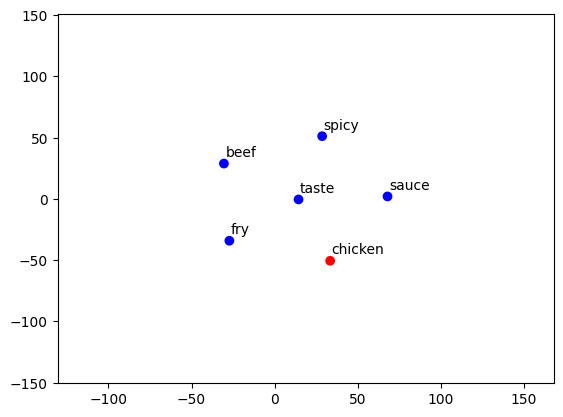

Word most similar to : chicken
['spicy', 'fry', 'sauce', 'beef', 'taste']


In [70]:
display_closestwords_tsnescatterplot_perso(model_W2V, simplified_documents[1][5])